In [1]:
# GPU info
!nvidia-smi

Fri Dec 11 01:29:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
import os

import tensorflow as tf
import keras.backend as K

from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pickle

In [4]:
import re
import string

import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv("/content/drive/My Drive/Duplicate Question Detection/quora_questions.csv")
#data.fillna("none value", inplace=True) # replace nan value to none
# drop the rows with null value
data.dropna(axis=0, inplace=True)
N=len(data)
print('Number of question pairs: ', N)
data.head()

Number of question pairs:  404348


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# def cut_to_max(text, max_len):
#     words = text.split()[:max_len]
#     return ' '.join(words)

# # test the func
# # cut_to_max(' abc test wewe dfd ddd', 3)

In [ ]:
# data['question1'] = data['question1'].apply(lambda x: cut_to_max(x, 65))
# data['question2'] = data['question2'].apply(lambda x: cut_to_max(x, 65))

In [7]:
# model selection
from sklearn.model_selection import train_test_split
data_train , data_test = train_test_split(data, train_size=0.75, random_state=0)
# validation_data, _ = train_test_split(data_train, train_size=0.1, random_state=0)
len(data_train), len(data_test)

(303261, 101087)

In [8]:
train_Q1 = np.array(data_train['question1'])
train_Q2 = np.array(data_train['question2'])
t_labels = np.array(data_train['is_duplicate'])
# make it one-hot encoding
train_labels = tf.keras.utils.to_categorical(t_labels, num_classes=2)

test_Q1 = np.array(data_test['question1'])
test_Q2 = np.array(data_test['question2'])
te_labels  = np.array(data_test['is_duplicate'])
# make it one-hot encoding
test_labels = tf.keras.utils.to_categorical(te_labels, num_classes=2)

In [9]:
#create arrays

Q1_train_tensor = np.empty_like(train_Q1)
Q2_train_tensor = np.empty_like(train_Q2)

Q1_test_tensor = np.empty_like(test_Q1)
Q2_test_tensor = np.empty_like(test_Q2)

Q1_train_tensor.shape, Q1_test_tensor.shape

((303261,), (101087,))

In [10]:
# tokenize
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()
def process_question(question):
    words = [word.lower() for word in tokenizer.tokenize(question)]
    # remove_stopwords = [word for word in words if word not in stopwords.words('english')]
    # stemmed_words = [stemmer.stem(word) for word in remove_stopwords]
    return words

In [11]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [12]:
# # process train and test questions

Q1_train_words = {}
Q2_train_words = {}

Q1_test_words = {}
Q2_test_words = {}

for idx in range(len(train_Q1)):
    Q1_train_words[idx] = text_to_word_list(train_Q1[idx])
    Q2_train_words[idx] = text_to_word_list(train_Q2[idx])

for idx in range(len(test_Q1)): 
    Q1_test_words[idx] = text_to_word_list(test_Q1[idx])
    Q2_test_words[idx] = text_to_word_list(test_Q2[idx])

In [ ]:
# # save the preprocessed questions

# file_name = open('Q1_test_words.p', 'wb')
# pickle.dump(Q1_test_words, file_name)
# file_name.close()

# file_name = open('Q2_test_words.p', 'wb')
# pickle.dump(Q2_test_words, file_name)
# file_name.close()

# # Copy the model files to a directory in your Google Drive.
# !cp "/content/Q1_test_words.p" "/content/drive/My Drive/Colab Notebooks/Q1_test_words.p"
# !cp "/content/Q2_test_words.p" "/content/drive/My Drive/Colab Notebooks/Q2_test_words.p"

In [ ]:
# # read the dictionaries
# Q1_train_words = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Q1_train_words.p', 'rb'))
# Q2_train_words = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Q2_train_words.p', 'rb'))

# Q1_test_words = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Q1_test_words.p', 'rb'))
# Q1_test_words = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Q1_test_words.p', 'rb'))


In [13]:
# make vocabulary 
vocab = {}
word_count = 0
for idx in range(len(train_Q1)):
    
    q = Q1_train_words[idx] + Q2_train_words[idx]
    for word in q:
        if word not in vocab:
            word_count += 1
            vocab[word] = word_count
print('The length of the vocabulary is: ', len(vocab))

The length of the vocabulary is:  76066


In [ ]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

In [15]:
!unzip '/content/drive/My Drive/Embeddings/crawl-300d-2M-subword.zip'

Archive:  /content/drive/My Drive/Embeddings/crawl-300d-2M-subword.zip
  inflating: crawl-300d-2M-subword.vec  
  inflating: crawl-300d-2M-subword.bin  


In [16]:
!cp '/content/crawl-300d-2M-subword.vec' '/content/drive/My Drive/Embeddings/crawl-300d-2M-subword.vec'

In [17]:
# import pre-trained word embeddings 
from gensim.models import KeyedVectors
embeddings = KeyedVectors.load_word2vec_format('/content/crawl-300d-2M-subword.vec', binary=False)

In [18]:
# get pre-trained embeddings
def get_word_embeddings(vocab, embeddings):
    vocab_len = len(vocab) + 2
    word_embeddings = np.zeros((vocab_len, 300))
    for word, i in vocab.items():
        if word in embeddings.vocab:
            word_embeddings[i] = embeddings[word]
    return word_embeddings

In [19]:
word_embeddings = get_word_embeddings(vocab, embeddings)
# remove memory
del(embeddings)

In [20]:
# Converting questions to array of integers
for i in range(len(train_Q1)):
    Q1_train_tensor[i] = [vocab.get(word, 0) for word in Q1_train_words[i]]
    Q2_train_tensor[i] = [vocab.get(word, 0) for word in Q2_train_words[i]]

        
for i in range(len(test_Q1)):
    Q1_test_tensor[i] = [vocab.get(word, 0) for word in Q1_test_words[i]]
    Q2_test_tensor[i] = [vocab.get(word, 0) for word in Q2_test_words[i]]

In [21]:
print('first question in the train set:\n')
print(train_Q1[0], '\n', ) 

print('encoded version:')
print(Q1_train_tensor[0],'\n')

print('first question in the test set:\n')
print(test_Q1[0], '\n')
print('encoded version:')
print(Q1_test_tensor[0]) 

first question in the train set:

Could Donald trump become the PM of India if he was an Indian politician? 

encoded version:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

first question in the test set:

What are some really delicious vegetarian recipes? 

encoded version:
[23, 24, 145, 866, 2342, 14467, 2653]


In [22]:
pad_sequences(Q1_train_tensor, maxlen=16, padding='post')
# Embedding(len(vocab), 4)(pad_sequences(Q1_test_tensor, maxlen=32, padding='post'))

array([[   1,    2,    3, ...,   14,    0,    0],
       [  23,   24,    5, ...,    0,    0,    0],
       [  41,   24,   42, ...,   43,   50,   51],
       ...,
       [ 114,   44,    5, ...,    0,    0,    0],
       [ 143,  102,   45, ...,   23,   44,  143],
       [  57,   54, 1687, ...,    0,    0,    0]], dtype=int32)

In [23]:
class data_generator(tf.keras.utils.Sequence):
    def __init__(self, Q1, Q2, labels, batch_size, max_len, shuffle=True):
        self.Q1 = Q1
        self.Q2 = Q2
        self.labels = labels
        self.batch_size = batch_size
        self.max_len = max_len
        self.shuffle = shuffle
        
        self.indexes = np.arange(len(self.Q1))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.Q1) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        input1 = self.Q1[indexes]
        input2 = self.Q2[indexes]
        targets = self.labels[indexes]
        
        pad_input1 = pad_sequences(input1, maxlen=self.max_len, padding='post')
        pad_input2 = pad_sequences(input2, maxlen=self.max_len, padding='post')

        return [pad_input1, pad_input2], targets


    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [24]:
# define model
def create_model(max_len, lstm_units, lr_rate, loss_fn):

    def exponent_neg_manhattan_distance(left, right):
        return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

    # Input tensor placeholders
    left_input = tf.keras.Input(shape=(max_len,), dtype='int32')
    right_input = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Embedding layer
    embedding_dim = 300
    embedding_layer = Embedding(len(vocab)+2, embedding_dim, weights=[word_embeddings], trainable=False)

    # Add the embedding dimension to input placeholders
    encoded_left = embedding_layer(left_input)
    encoded_right = embedding_layer(right_input)   

    # Initialise the LSTM
    shared_lstm = tf.keras.layers.LSTM(lstm_units)
    encoded_l = shared_lstm(encoded_left)
    encoded_r = shared_lstm(encoded_right)     

    # Calculates the manhattan distance
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = tf.keras.layers.Lambda(lambda tensors: exponent_neg_manhattan_distance(tensors[0], tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(L1_distance)

    # Build the model
    model = tf.keras.Model(inputs=[left_input, right_input], outputs=[L1_distance])

    # compile model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate),
        loss = loss_fn,
        metrics = ['accuracy'],
    )

    return model
    

In [25]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    loss_fn = tf.keras.losses.MeanSquaredError()
    model = create_model(max_len = 64,
                        lstm_units = 64,
                        lr_rate = 0.001,
                        loss_fn = loss_fn
                    )

# print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 300)      22820400    input_1[0][0]                    
                                                                 input_2[0][0]                    
____________________________________________________________________________________

In [26]:
batch_size = 256
train_data = data_generator(
    Q1_train_tensor, 
    Q2_train_tensor, 
    t_labels, 
    batch_size, 
    64,
    )
valid_data = data_generator(
    Q1_test_tensor, 
    Q2_test_tensor, 
    te_labels, 
    batch_size, 
    64,
    shuffle=False,
    )

In [ ]:
# change learning rate

tf.keras.backend.set_value(model.optimizer.lr, 0.001)
print(tf.keras.backend.get_value(model.optimizer.lr))

0.001


In [27]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [28]:
epochs = 100
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    callbacks = [callback],
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:C

In [29]:
preds = model.predict(
    valid_data,
    batch_size=batch_size,
    use_multiprocessing=True
)


In [30]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
y_pred = np.where(preds > 0.5, 1, 0)
n = y_pred.shape[0]
y_true = te_labels[:n]
print('accuracy: ', accuracy_score(y_true, y_pred))
print('F1 score: ', f1_score(y_true, y_pred))
print('Recall score: ', recall_score(y_true, y_pred))
print('confusion matrix: \n', confusion_matrix(y_true, y_pred))

accuracy:  0.8227910850253807
F1 score:  0.7485156315952387
Recall score:  0.7160354249104955
confusion matrix: 
 [[56390  7325]
 [10549 26600]]


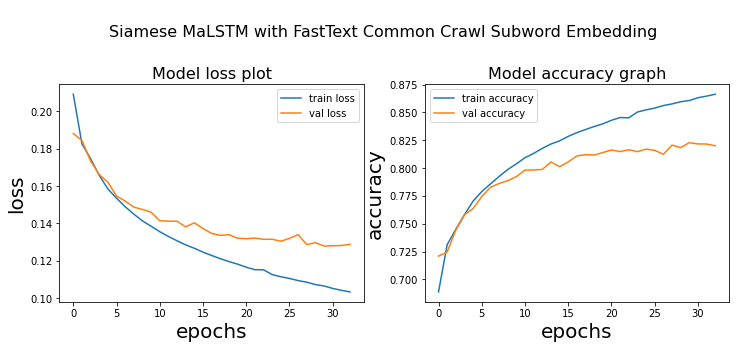

In [31]:
# draw plots
fig, axs = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('\nSiamese MaLSTM with FastText Common Crawl Subword Embedding', x=0.5, y=1.15,fontsize=16)

axs[0].plot(history.history['loss'], label='train loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('\nModel loss', fontsize=16)
axs[0].set_xlabel('epochs', fontsize=20)
axs[0].set_ylabel('loss', fontsize=20)
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='train accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('\nModel accuracy', fontsize=16)
axs[1].set_xlabel('epochs', fontsize=20)
axs[1].set_ylabel('accuracy', fontsize=20)
axs[1].legend()

plt.show()